In [86]:
import numpy as np
import os

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from livelossplot import PlotLossesKeras

import warnings
warnings.filterwarnings('ignore')

## Structuring Extracted Key Points

In [4]:
actions = ['go', 'thin', 'drink']

In [5]:
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'go': 0, 'thin': 1, 'drink': 2}

In [9]:
# now we have to structure our data
# our data should look like (44, 30, 1662)
# we have 44 videos in total,
# each video consists of 30 frames,
# and each frame has 1662 extracted values

sequence_length = 30
sequences, labels = [], []

for action in os.listdir('Extracted'):
    for each_vid in os.listdir(os.path.join('Extracted', action)):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join('Extracted', action, each_vid, "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [74]:
X = np.array(sequences)
Y = to_categorical(np.array(labels)).astype(int)

X.shape, Y.shape

((44, 30, 1662), (44, 3))

In [75]:
#np.save('data', data)

In [76]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
x_train.shape, x_test.shape

((35, 30, 1662), (9, 30, 1662))

## LSTM Architecture

In [77]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(actions), activation='softmax'))

In [78]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 30, 64)            442112    
                                                                 
 lstm_28 (LSTM)              (None, 30, 128)           98816     
                                                                 
 lstm_29 (LSTM)              (None, 64)                49408     
                                                                 
 dense_27 (Dense)            (None, 64)                4160      
                                                                 
 dense_28 (Dense)            (None, 32)                2080      
                                                                 
 dense_29 (Dense)            (None, 3)                 99        
                                                                 
Total params: 596,675
Trainable params: 596,675
Non-tr

In [79]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

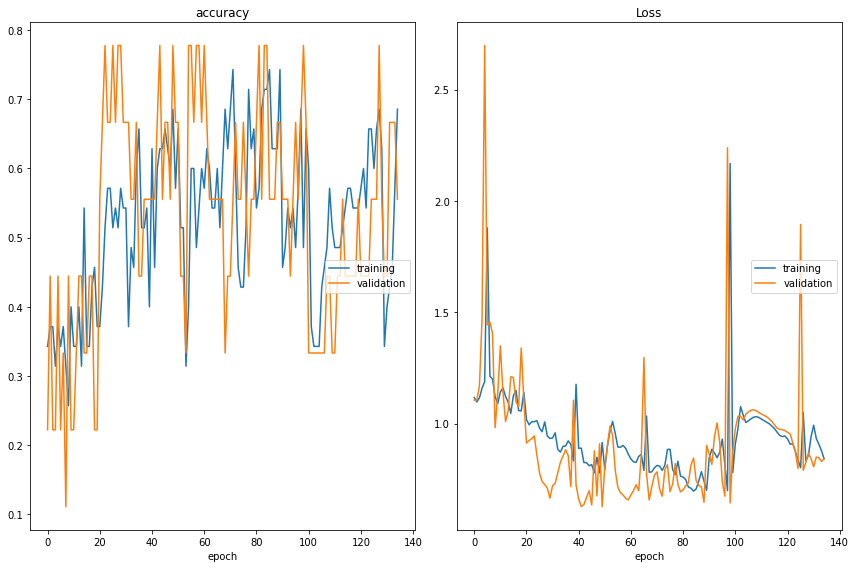

accuracy
	training         	 (min:    0.257, max:    0.743, cur:    0.686)
	validation       	 (min:    0.111, max:    0.778, cur:    0.556)
Loss
	training         	 (min:    0.697, max:    2.168, cur:    0.842)
	validation       	 (min:    0.627, max:    2.698, cur:    0.842)


In [80]:
es = EarlyStopping(monitor = 'loss',
                   patience = 50,
                   verbose = 0,
                   restore_best_weights = True)

model.fit(x_train, y_train, epochs=800, callbacks=[PlotLossesKeras(), es], verbose=0, validation_data=(x_test, y_test))

In [81]:
model.save("sign_language_model.h5")

In [85]:
actions[np.argmax(y_pred[4])], actions[np.argmax(y_test[4])]

('go', 'go')

In [87]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1).tolist()
y_truth = np.argmax(y_test, axis=1).tolist()

1/1 [==============================] - 0s 58ms/step


In [88]:
accuracy_score(y_truth, y_pred)

0.7777777777777778

In [89]:
multilabel_confusion_matrix(y_truth, y_pred)

array([[[4, 1],
        [0, 4]],

       [[6, 1],
        [1, 1]],

       [[6, 0],
        [1, 2]]], dtype=int64)

## Realtime Testing